# Clasificación de Sentimientos en Tweets

## Objetivos:

El objetivo de este proyecto es enfrentarse a un problema de clasificación de texto real: tweets descargados sobre las elecciones de EEUU en 2016, centrándonos en el preprocesamiento, que en este caso es crucial en un problema en el que el protagonista es el texto.

## Inicialización del entorno:

In [147]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

random.seed(1234)
pd.set_option('display.max_colwidth', 175) # incrementamos anchura de output

In [148]:
df_train = pd.read_csv('./data/gop_tweets_train_psn.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8414 entries, 0 to 8413
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  8414 non-null   object
 1   text       8414 non-null   object
dtypes: object(2)
memory usage: 131.6+ KB


In [149]:
df_test = pd.read_csv('./data/gop_tweets_test_psn.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2153 entries, 0 to 2152
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  2153 non-null   object
 1   text       2153 non-null   object
dtypes: object(2)
memory usage: 33.8+ KB


Damos un vistazo a los textos que aparecen en el dataset.

In [150]:
df_train.head()

,sentiment,text
0,Neutral,RT @NancyLeeGrahn: How did everyone feel about the Climate Change question last night? Exactly. #GOPDebate
1,Positive,RT @ScottWalker: Didn't catch the full #GOPdebate last night. Here are some of Scott's best lines in 90 seconds. #Walker16 http://t.co/ZSfF…
2,Neutral,RT @TJMShow: No mention of Tamir Rice and the #GOPDebate was held in Cleveland? Wow.
3,Positive,RT @RobGeorge: That Carly Fiorina is trending -- hours after HER debate -- above any of the men in just-completed #GOPdebate says she's on …
4,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump delivered the highest ratings in the history of presidential debates. #Trump2016 http://t.co…


In [151]:
df_test.head()

,sentiment,text
0,Positive,"RT @GregAbbott_TX: @TedCruz: ""On my first day I will rescind every illegal executive action taken by Barack Obama."" #GOPDebate @FoxNews"
1,Neutral,Going on #MSNBC Live with @ThomasARoberts around 2 PM ET. #GOPDebate
2,Positive,RT @WayneDupreeShow: Just woke up to tweet this out #GOPDebate \r\n\r\nBest line of the night via @GovMikeHuckabee http://t.co/6OV5hxHIcV
3,Negative,reason comment is funny 'in case you're ignorant' is the #gop #tcot are the reason the government isn't working for the people #gopdebate
4,Positive,"RT @ChuckNellis: Cruz has class &amp; truth, that gets my vote! #GOPDebate"


## ¿Qué número de tweets tenemos en cada dataset? ¿Cuántos de cada clase?

In [152]:
# Análisis de la distribución de clases en los datasets
print("Dataset de entrenamiento:")
print(df_train['sentiment'].value_counts())
print("\nDataset de test:")
print(df_test['sentiment'].value_counts())

Dataset de entrenamiento:
sentiment
Negative    4872
Neutral     2162
Positive    1380
Name: count, dtype: int64

Dataset de test:
sentiment
Negative    1257
Neutral      567
Positive     329
Name: count, dtype: int64


## ¿Qué dificultades crees que presenta la diferencia entre la cantidad de clases?

In [153]:
# Las dificultades que presenta el desbalanceo de clases son:
#   El modelo puede sesgarse hacia la clase mayoritaria
#   Las métricas de evaluación pueden ser engañosas
#   El modelo puede tener dificultades para aprender patrones de las clases minoritarias

## Clasificador de tweets

Vamos a construir nuestro propio clasificador sobre los tweets que hemos cargado. Los pasos que seguiremos serán:

* Preprocesar ambos conjuntos de tweets por separado.
* Entrenar clasificador con tweets de entrenamiento.
* Evaluar con tweets de test.

Primero, haremos una prueba para observar el rendimiento de nuestro clasificador sin ningún tipo de preprocesamiento.

In [154]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

Seguimos creando el clasificador y entrenando con el conjunto de entrenamiento de los tweets.

In [155]:
# creamos nuestro pipeline con vectorizador (bag of words) y clasificador
text_clf_sin_prep = Pipeline([('vect', CountVectorizer()),
                     ('clf', LinearSVC(max_iter=1200))])

# entrenamos el clasificador
text_clf_sin_prep.fit(df_train['text'], df_train['sentiment'])


Pipeline(steps=[('vect', CountVectorizer()), ('clf', LinearSVC(max_iter=1200))])

Realizamos las predicciones con el conjunto de test y obtenemos la métrica de evaluación.

In [156]:
predicted_sin_prep = text_clf_sin_prep.predict(df_test['text'])
accuracy = np.mean(predicted_sin_prep == df_test['sentiment'])
print("\nAccuracy:", accuracy)


Accuracy: 0.5973060845332094


Parece que hemos obtenido un resultado un poco peor... Ahora es cuando entra en juego el preprocesamiento del texto.

Ahora vamos a preprocesar el texto y construir un clasificador. Para ello, se ha creado esta función que nos automatiza el preprocesamiento. Deberás añadir el código que creas necesario y ejecutar la función para obtener el texto preprocesado. 

**Puedes definir todas las funciones de preprocesado que creas necesario, pero ten en cuenta varios detalles:**
* La funcion `preprocesar_texto` es llamada desde un `apply`. Esto significa que la función recibe un tweet y devuelve un tweet preprocesado con cada llamada. 
* Si el preprocesado es muy agresivo, un tweet puede quedarse fácilmente vacío, en esos casos el clasificador no podrá trabajar con él y escupirá la clase mayoritaria para ese tweet.
* Algunas técnicas no tienen sentido si se aplican después de otras dentro del pipeline. Por ejemplo, no tiene sentido aplicar POS después de realizar Stemming.
* Count Vectorizer necesita DOCUMENTOS y al trabajar con texto muchas veces es más sencillo hacer uso de TOKENS. Esto significa que tendremos que pasar cada tweet preprocesado en una cadena de texto. La función `" ".join(palabras)` que vimos en el worksheet es tu aliada.
* Si tu preprocesamiento va a ser intensivo, quizás es buena idea crear varias funciones que sean llamadas desde `preprocesar_texto`.

In [157]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

# Descargar recursos necesarios de NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/odremanferrer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/odremanferrer/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/odremanferrer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [158]:
def preprocesar_texto(texto):
    """Preprocesa el texto aplicando varias técnicas."""
    # Inicializar tokenizer especial para tweets
    tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
    
    # Convertir a minúsculas
    texto = texto.lower()
    
    # Eliminar URLs
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE)
    
    # Tokenización 
    tokens = tokenizer.tokenize(texto)
    
    # Eliminar stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Eliminar puntuación y números
    tokens = [token for token in tokens if token.isalpha()]
    
    # Lematización
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

In [159]:
# Con el preprocesamiento se han eliminado URLs, menciones y stopwords, y se ha convertido el texto a minúsculas. 
# Esto ha simplificado los tweets, 
# pero, también puede haber eliminado información contextual.

Aplicamos el preprocesamiento a los dos conjuntos de tweets y lo guardamos en la columna `prep`.

In [160]:
# Aplicar preprocesamiento a ambos datasets
df_train['prep'] = df_train['text'].apply(preprocesar_texto)
df_test['prep'] = df_test['text'].apply(preprocesar_texto)

In [161]:
# Visualizar ejemplos
print("Ejemplos de preprocesamiento:")
for i in range(3):
    print("\nOriginal:", df_train['text'].iloc[i])
    print("Preprocesado:", df_train['prep'].iloc[i])

Ejemplos de preprocesamiento:

Original: RT @NancyLeeGrahn: How did everyone feel about the Climate Change question last night? Exactly. #GOPDebate
Preprocesado: rt everyone feel climate change question last night exactly

Original: RT @ScottWalker: Didn't catch the full #GOPdebate last night. Here are some of Scott's best lines in 90 seconds. #Walker16 http://t.co/ZSfF…
Preprocesado: rt catch full last night best line second

Original: RT @TJMShow: No mention of Tamir Rice and the #GOPDebate was held in Cleveland? Wow.
Preprocesado: rt mention tamir rice held cleveland wow


In [162]:
#  El preprocesamiento ha reducido los tweets a sus componentes más básicos, lo que puede ser útil para eliminar el ruido, pero,
#   También podría eliminar matices importantes?

Antes de reentrenar nuestro clasificador, siempre es recomendable dar un vistazo al resultado del texto dentro del dataframe. También observar frecuencia de palabras o simplemente generar un WordCloud.

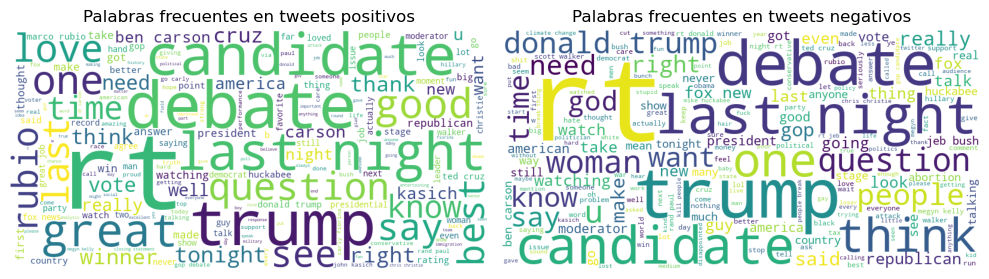

In [163]:
# WordCloud para tweets positivos
positive_text = ' '.join(df_train[df_train['sentiment'] == 'Positive']['prep'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(wordcloud_positive)
plt.title('Palabras frecuentes en tweets positivos')
plt.axis('off')

# WordCloud para tweets negativos
negative_text = ' '.join(df_train[df_train['sentiment'] == 'Negative']['prep'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.subplot(1,2,2)
plt.imshow(wordcloud_negative)
plt.title('Palabras frecuentes en tweets negativos')
plt.axis('off')
plt.tight_layout()
plt.show()

In [164]:
# Las palabras mas comunes son candidato, Trump, debate, última noche, lo que indica que estos son temas 
# centrales en los tweets positivos y negativos.


Ahora sí, vamos a reentrenar el clasificador y evaluar de nuevo. Puedes hacer uso del mismo pipeline anterior o simplemente crear uno nuevo con más etapas.

In [165]:
# Nuevo pipeline si es necesario. Por defecto usamos el anterior. Recuerda RE-ENTRENAR en cualquier caso!
#new_clf = text_clf
new_clf = text_clf_sin_prep

In [166]:
# Pipeline mejorado
new_clf = Pipeline([
    ('vect', CountVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95
    )),
    ('tfidf', TfidfTransformer(
        use_idf=True,
        smooth_idf=True,
        sublinear_tf=True
    )),
    ('clf', LinearSVC(
        dual='auto',
        class_weight='balanced',
        max_iter=2000
    ))
])

In [167]:
# Entrenamiento
new_clf.fit(df_train['prep'], df_train['sentiment'])


Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer(sublinear_tf=True)),
                ('clf',
                 LinearSVC(class_weight='balanced', dual='auto',
                           max_iter=2000))])

#Predicción haciendo uso del pipeline correspondiente. ¡Recuerda cambiarlo si has creado uno nuevo!

In [168]:
# Predicción y evaluación
predicted_con_prep = new_clf.predict(df_test['prep'])
accuracy = np.mean(predicted_con_prep == df_test['sentiment'])
print("\nAccuracy:", accuracy)

# Reporte detallado de clasificación
print("\nReporte de clasificación:")
print(classification_report(df_test['sentiment'], predicted_con_prep))


Accuracy: 0.5926614026939154

Reporte de clasificación:
              precision    recall  f1-score   support

    Negative       0.72      0.70      0.71      1257
     Neutral       0.43      0.44      0.43       567
    Positive       0.40      0.43      0.42       329

    accuracy                           0.59      2153
   macro avg       0.52      0.53      0.52      2153
weighted avg       0.60      0.59      0.59      2153



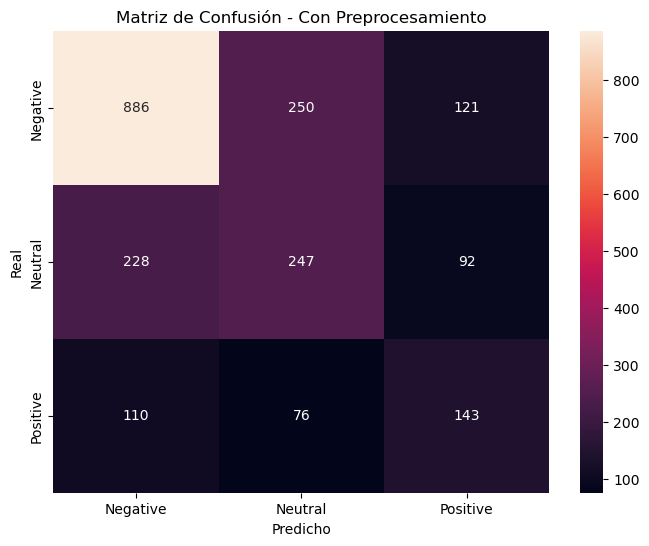

In [169]:
# Matriz de confusión con preprocesamiento
plt.figure(figsize=(8,6))
cm_con_prep = confusion_matrix(df_test['sentiment'], predicted_con_prep)
sns.heatmap(cm_con_prep, annot=True, fmt='d',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Matriz de Confusión - Con Preprocesamiento')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

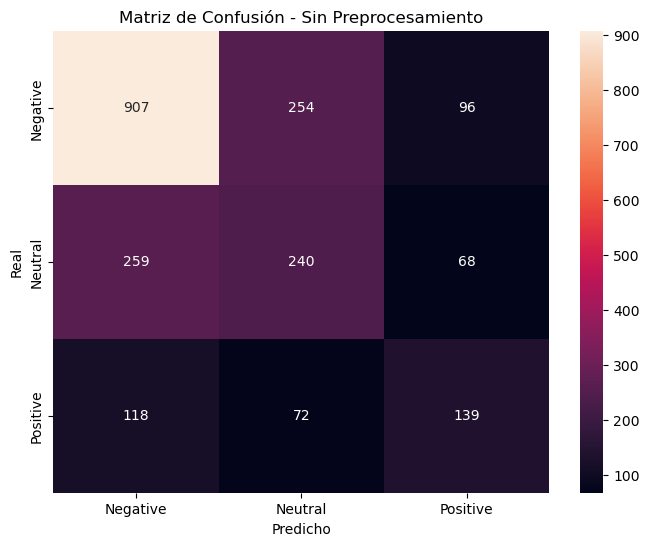

In [170]:
# Matriz de confusión sin preprocesamiento
plt.figure(figsize=(8,6))
cm_sin_prep = confusion_matrix(df_test['sentiment'], predicted_sin_prep)
sns.heatmap(cm_sin_prep, annot=True, fmt='d',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Matriz de Confusión - Sin Preprocesamiento')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

In [171]:
# Comparación de resultados
print("\nComparación de accuracies:")
print(f"Accuracy sin preprocesamiento: {np.mean(predicted_sin_prep == df_test['sentiment']):.4f}")
print(f"Accuracy con preprocesamiento: {np.mean(predicted_con_prep == df_test['sentiment']):.4f}")


Comparación de accuracies:
Accuracy sin preprocesamiento: 0.5973
Accuracy con preprocesamiento: 0.5927


#¿Qué opinas de los resultados obtenidos?



In [172]:
"""
Analizando los resultados de la matriz de confusión:
1. La clase Negative tiene el mejor rendimiento: 886 predicciones correctas de 1257 casos (70.5%)
2. La clase Neutral tiene rendimiento moderado: 247 predicciones correctas de 567 casos (43.6%)
3. La clase Positive tiene el rendimiento más bajo: 143 predicciones correctas de 329 casos (43.5%)

El modelo tiene una tendencia a clasificar incorrectamente tweets positivos y neutrales como negativos:
- 228 tweets neutrales fueron clasificados como negativos
- 110 tweets positivos fueron clasificados como negativos
"""

'\nAnalizando los resultados de la matriz de confusión:\n1. La clase Negative tiene el mejor rendimiento: 886 predicciones correctas de 1257 casos (70.5%)\n2. La clase Neutral tiene rendimiento moderado: 247 predicciones correctas de 567 casos (43.6%)\n3. La clase Positive tiene el rendimiento más bajo: 143 predicciones correctas de 329 casos (43.5%)\n\nEl modelo tiene una tendencia a clasificar incorrectamente tweets positivos y neutrales como negativos:\n- 228 tweets neutrales fueron clasificados como negativos\n- 110 tweets positivos fueron clasificados como negativos\n'

#¿Por qué crees que ha sucedido esto?

In [173]:
"""
Las razones principales son:
1. Desbalanceo severo de clases: La clase Negative (4872) tiene casi 4 veces más muestras que 
   la clase Positive (1380) en el conjunto de entrenamiento.
2. Confusión entre clases: Hay una superposición significativa entre las características de 
   tweets neutrales y positivos/negativos.
3. Pérdida de contexto: El preprocesamiento puede haber eliminado información importante como 
   emojis, hashtags o estructura de las oraciones que ayudan a distinguir el sentimiento.
4. Sesgo del modelo: A pesar de usar class_weight='balanced', el modelo sigue mostrando 
   una tendencia hacia la clase mayoritaria (Negative).
"""

"\nLas razones principales son:\n1. Desbalanceo severo de clases: La clase Negative (4872) tiene casi 4 veces más muestras que \n   la clase Positive (1380) en el conjunto de entrenamiento.\n2. Confusión entre clases: Hay una superposición significativa entre las características de \n   tweets neutrales y positivos/negativos.\n3. Pérdida de contexto: El preprocesamiento puede haber eliminado información importante como \n   emojis, hashtags o estructura de las oraciones que ayudan a distinguir el sentimiento.\n4. Sesgo del modelo: A pesar de usar class_weight='balanced', el modelo sigue mostrando \n   una tendencia hacia la clase mayoritaria (Negative).\n"

¿Podrías explicarme con tus palabras en qué consiste Tf-Idf? ¿Cual es la idea intuitiva de aplicar esta transformación a la matriz?

In [174]:
"""
TF-IDF (Term Frequency-Inverse Document Frequency) combina:

1. TF (Term Frequency): Cuenta cuántas veces aparece una palabra en un tweet
2. IDF (Inverse Document Frequency): Mide qué tan única es una palabra en todos los tweets

La idea de usar TF-IDF es:
- Dar más importancia a palabras que son relevantes para un tweet específico
- Reducir el peso de palabras comunes que aparecen en muchos tweets
- Ayudar a identificar mejor las palabras que caracterizan el sentimiento
"""

'\nTF-IDF (Term Frequency-Inverse Document Frequency) combina:\n\n1. TF (Term Frequency): Cuenta cuántas veces aparece una palabra en un tweet\n2. IDF (Inverse Document Frequency): Mide qué tan única es una palabra en todos los tweets\n\nLa idea de usar TF-IDF es:\n- Dar más importancia a palabras que son relevantes para un tweet específico\n- Reducir el peso de palabras comunes que aparecen en muchos tweets\n- Ayudar a identificar mejor las palabras que caracterizan el sentimiento\n'